# Style transfer using VGG16 network

* `A Neural Algorithm of Artistic Style`, [arXiv:1508.06576](https://arxiv.org/abs/1508.06576)
* Leon A. Gatys, Alexander S. Ecker, and, Matthias Bethge


* `models/research/slim/nets`을 이용하여 만듦
* `image_size`를 input_image에 맞게 조절 (최대 이미지 길리 max_L=1024 로 고정)
* 원래 논문처럼 `average_pooling` 사용
* loss는 논문에 나온 그대로 사용 (조금 맘에 안들지만)
* hyperparameter들은 cs20 코드를 참조함
* input_image는 우리집 고양이
* style_image는 [Starry Night](https://en.wikipedia.org/wiki/The_Starry_Night)

In [1]:
#import sys
#sys.path.append("$HOME/models/research/slim/")

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="1"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Hyperparameters setting

In [2]:
input_data_dir = '../input_data/'
content_image_name = 'my_cat1.jpg'
style_image_name = 'Gogh_The_Starry_Night.jpg'
noise_ratio = 0.6
max_L = 1024 # upper bound of image size
style_loss_weight = np.array([0.5, 1.0, 1.5, 3.0, 4.0])
content_weight = 0.00001
style_weight = 1.0
learning_rate = 0.1
max_steps = 1000
print_steps = 100

### Load a VGG16 graph

In [3]:
def vgg_16(inputs,
           reuse=False,
           scope='vgg_16'):
  """Oxford Net VGG 16-Layers version D Example
  
  My Note: This code is modified version of vgg_16 which is loacted on `models/research/slim/nets/vgg.py`
  Note: All the fully_connected layers have been transformed to conv2d layers.
        To use in classification mode, resize input to 224x224.

  Args:
    inputs: a tensor of size [batch_size, height, width, channels].
    reuse: whether or not the model is being reused.
    scope: Optional scope for the variables.

  Returns:
    net: the output of the logits layer (if num_classes is a non-zero integer),
      or the input to the logits layer (if num_classes is 0 or None).
    end_points: a dict of tensors with intermediate activations.
  """
  with tf.variable_scope(scope, 'vgg_16', [inputs], reuse=reuse) as sc:
    end_points_collection = sc.original_name_scope + '_end_points'
    with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.max_pool2d],
                        outputs_collections=end_points_collection):
      # 여기를 직접 채워 넣으시면 됩니다.
      net = 
      net = 
      net = 
      net = 
      net = 
      net = 
      net = 
      net = 
      net = 
      net = 

      end_points = slim.utils.convert_collection_to_dict(end_points_collection)

      return net, end_points

### Read content image and style image

In [4]:
content_image_ = Image.open(os.path.join(input_data_dir, content_image_name))
style_image_ = Image.open(os.path.join(input_data_dir, style_image_name))

In [5]:
def image_resize_with_upper_bound(image, max_L=max_L):
  """Resize images
  
  Args:
    image: PIL image format
    max_L: upper bound of the image size
    
  Returns:
    image: resized image with PIL format
    h: resized height
    w: resized width
    """
  w, h = image.size
  if np.max(np.array([h, w])) > max_L:
    if h < w:
      h = int(max_L * h / w)
      w = max_L
    else:
      w = int(max_L * w / h)
      h = max_L
  image = image.resize((h, w))
  
  return image, h, w

In [6]:
content_image_, content_image_h, content_image_w = image_resize_with_upper_bound(content_image_)
style_image_w, style_image_h = style_image_.size

In [7]:
# 여기를 직접 채워 넣으시면 됩니다.
content_image_p = tf.placeholder()
style_image_p = tf.placeholder()
# content_image, style_image를 tf.Variable로 바꾸기 위해 tf.placeholder와 같은 shape의 zero Tensor를 만듦
content_image = tf.get_variable()
style_image = tf.get_variable()
generated_image = tf.get_variable(name='generated_image',
                                  shape=[1, image_h, image_w, 3],
                                  initializer=tf.random_uniform_initializer(minval=-0.2, maxval=0.2))
# tf.placeholder를 tf.Variable로 바꿈
content_image_op = content_image.assign(content_image_p)
style_image_op = style_image.assign(style_image_p)
# 초기 이미지는 content_image에 random noise를 섞음
generated_image_op = generated_image.assign(generated_image * noise_ratio + \
                                            content_image_p * (1.0 - noise_ratio))
# 여기를 직접 채워 넣으시면 됩니다.
# generated_image는 매 update 후에 [-1, 1] 사이로 clipping
generated_image_clipping = generated_image.assign()

In [8]:
# 여기를 직접 채워 넣으시면 됩니다.
_, feature_maps_c = vgg_16() # input: content_image
_, feature_maps_s = vgg_16() # input: style_image
_, feature_maps_g = vgg_16() # input: generated_image

In [9]:
with tf.Session() as sess:
  writer = tf.summary.FileWriter("./graphs/02_style_transfer", sess.graph)
  writer.close()

## Build a model

### collecte feature maps

* content layers
  * `conv4_2`: key name -> 'vgg16/vgg_16/conv4/conv4_2'
* style layers
  * `conv1_1`: key name -> 'vgg16/vgg_16/conv1/conv1_1'
  * `conv2_1`: key name -> 'vgg16/vgg_16/conv2/conv2_1'
  * `conv3_1`: key name -> 'vgg16/vgg_16/conv3/conv3_1'
  * `conv4_1`: key name -> 'vgg16/vgg_16/conv4/conv4_1'
  * `conv5_1`: key name -> 'vgg16/vgg_16/conv5/conv5_1'

In [10]:
content_layers = feature_maps_c['vgg_16/conv4/conv4_2']
style_layers = [feature_maps_s['vgg_16/conv1/conv1_1'],
                feature_maps_s['vgg_16/conv2/conv2_1'],
                feature_maps_s['vgg_16/conv3/conv3_1'],
                feature_maps_s['vgg_16/conv4/conv4_1'],
                feature_maps_s['vgg_16/conv5/conv5_1']]
generated_layers = [feature_maps_g['vgg_16/conv4/conv4_2'],
                    feature_maps_g['vgg_16/conv1/conv1_1'],
                    feature_maps_g['vgg_16/conv2/conv2_1'],
                    feature_maps_g['vgg_16/conv3/conv3_1'],
                    feature_maps_g['vgg_16/conv4/conv4_1'],
                    feature_maps_g['vgg_16/conv5/conv5_1']]

### content loss

In [11]:
def content_loss(P, F, scope):
  """Calculate the content loss function between
  the feature maps of content image and generated image.
  
  Args:
    P: the feature maps of the content image
    F: the feature maps of the generated image
    scope: scope
    
  Returns:
    loss: content loss (mean squared loss)
  """
  # 여기를 직접 채워 넣으시면 됩니다.
  loss = 
  return 

### style loss

In [12]:
def style_loss(style_layers, generated_layers, scope):
  """Calculate the style loss function between
  the gram matrix of feature maps of style image and generated image.
  
  Args:
    style_layers: list of the feature maps of the style image
    generated_layers: list of the feature maps of the generated image
    scope: scope
    
  Returns:
    loss: style loss (mean squared loss)
  """
  def _style_loss_one_layer(feature_map_s, feature_map_g):
    """Calculate the style loss for one layer.
    
    Args:
      feature_map_s: the feature map of the style image
        - G: the gram matrix of the feature_map_s
      feature_map_g: the feature map of the generated image
        - A: the gram matrix of the feature_map_g
      
    Returns:
      loss: style loss for one layer (mean squared loss)
    """
    _, h, w, c = feature_map_s.get_shape().as_list()
    G = _gram_matrix(feature_map_s)
    A = _gram_matrix(feature_map_g)
    # 여기를 직접 채워 넣으시면 됩니다.
    loss = 
    return 
  
  def _gram_matrix(feature_map):
    """Calculate the gram matrix for the feature map
    
    Args:
      feature_map: 4-rank Tensor [1, height, width, channels]
        - F = 2-rank Tensor [h * w, channels]
      
    Returns:
      gram_matrix: 2-rank Tensor [c, c] (F.transpose x F)
    """
    # 여기를 직접 채워 넣으시면 됩니다.
    F = tf.squeeze()
    h, w, c = F.shape
    F = tf.reshape()
    return 
    
    
  assert len(style_layers) == len(generated_layers)
  
  loss = 0.0
  for i in range(len(style_layers)):
    loss_one = _style_loss_one_layer(style_layers[i], generated_layers[i])
    loss += loss_one * style_loss_weight[i]

  return loss * 0.25

### Total loss

In [13]:
loss_c = content_loss(content_layers, generated_layers[0],
                      scope='content_loss')
loss_s = style_loss(style_layers, generated_layers[1:],
                    scope='style_loss')

with tf.variable_scope('total_loss'):
  total_loss = content_weight * loss_c + style_weight * loss_s

### Define a optimizer

In [14]:
# 여기를 직접 채워 넣으시면 됩니다.
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize()

### Restore VGG16 weights using `tf.saver.restore`

### Download the VGG16 checkpoint: 

```
$ CHECKPOINT_DIR='./checkpoints'
$ mkdir ${CHECKPOINT_DIR}
$ cd ${CHECKPOINT_DIR}
$ wget http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
$ tar -xvf vgg_16_2016_08_28.tar.gz
$ rm vgg_16_2016_08_28.tar.gz
```

### Preprocessing a image

In [15]:
def image_preprocessing(image):
  """image preprocessing
  transform image pixel value: int [0, 255] -> float [-1.0, 1.0]

  Args:
    image: PIL image format
  
  Returns:
    image: float type numpy array with shape [1, image_h, image_w, 3] which is in [-1, 1]
  """
  image = np.asarray(image) / 255.
  image -= 0.5
  image *= 2.0

  image = np.expand_dims(image, axis=0)
  return image 

In [16]:
def print_image(image):
  """print image
  
  Args:
    image: 4-rank np.array [1, h, w, 3]
  """
  print_image = np.squeeze(image, axis=0)
  print_image = np.clip(print_image, -1.0, 1.0)
  print_image += 1.0
  print_image *= 0.5
  
  plt.axis('off')
  plt.imshow(print_image)
  plt.show()

In [17]:
content_image_ = image_preprocessing(content_image_)
style_image_ = image_preprocessing(style_image_)

In [18]:
v = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='vgg_16')

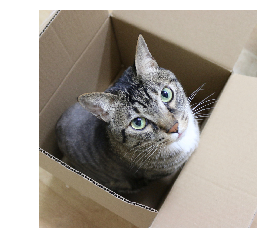

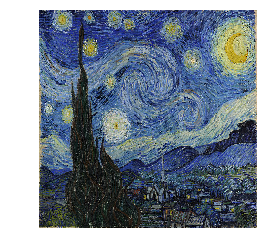

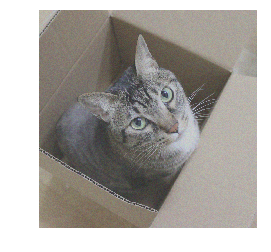

INFO:tensorflow:Restoring parameters from ../checkpoints/vgg_16.ckpt
step: 0  loss: 6733878.5  duration: 2.945589542388916


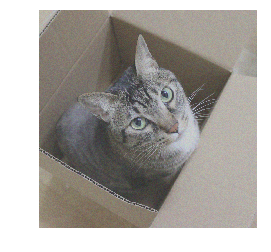

step: 100  loss: 6226.90625  duration: 24.873215198516846


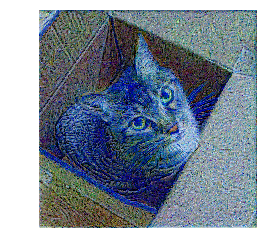

step: 200  loss: 1566.347900390625  duration: 25.17957901954651


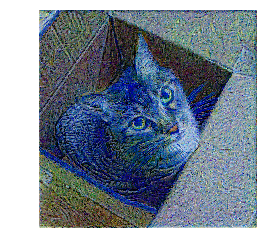

step: 300  loss: 886.8645629882812  duration: 25.49780583381653


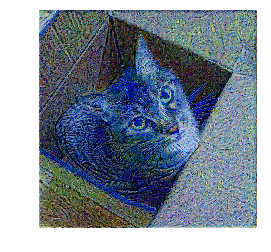

step: 400  loss: 637.4721069335938  duration: 25.745235443115234


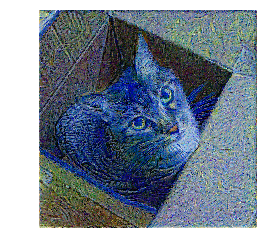

step: 500  loss: 507.54693603515625  duration: 25.72929072380066


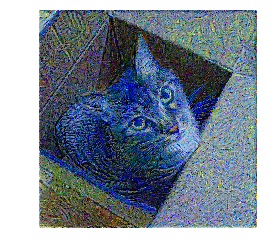

step: 600  loss: 427.421875  duration: 25.733644723892212


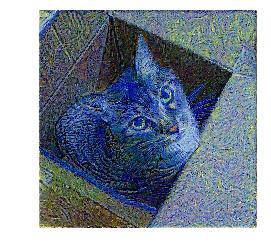

step: 700  loss: 373.33990478515625  duration: 25.71517848968506


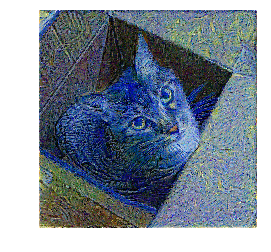

step: 800  loss: 334.610595703125  duration: 25.750513553619385


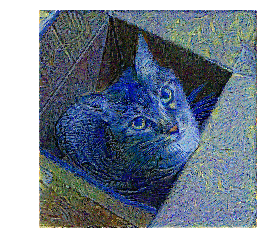

step: 900  loss: 463.90386962890625  duration: 25.753051042556763


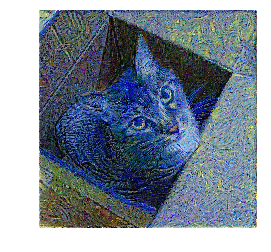

step: 1000  loss: 289.6109313964844  duration: 25.74506902694702


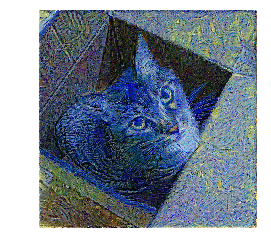

training done!


In [19]:
saver = tf.train.Saver(var_list=v)

with tf.Session(config=sess_config) as sess:
  sess.run(tf.global_variables_initializer())
  # content_image_와 style_image_를 tf.placeholder에 넣고 tf.Variable로 assign
  sess.run([content_image_op, style_image_op, generated_image_op],
           feed_dict={content_image_p: content_image_,
                      style_image_p: style_image_})

  _, generated_image_ = sess.run([generated_image_clipping, generated_image])
  print_image(content_image_)
  print_image(style_image_)
  print_image(generated_image_) # initial_image = content_image + small noise

  # use saver object to load variables from the saved model
  saver.restore(sess, "../checkpoints/vgg_16.ckpt")
  
  start_time = time.time()
  for step in range(max_steps+1):
    _, loss_, _, generated_image_ = \
        sess.run([train_op, total_loss, generated_image_clipping, generated_image])
    if step % print_steps == 0:
      duration = time.time() - start_time
      start_time = time.time()
      print("step: {}  loss: {}  duration: {}".format(step,
                                                      loss_,
                                                      duration))
      print_image(generated_image_)
  print('training done!')

In [20]:
def save_image(image, content_image_name, style_image_name):
  """print image
  
  Args:
    image: 4-rank np.array [1, h, w, 3]
    filename: name of saved image
  """
  save_image = np.squeeze(image, axis=0)
  save_image = np.clip(save_image, -1.0, 1.0)
  save_image += 1.0
  save_image /= 2.0
  
  save_image = Image.fromarray(np.uint8(save_image*255))
  filename = os.path.splitext(os.path.basename(content_image_name))[0] + '_'
  filename += os.path.splitext(os.path.basename(style_image_name))[0] + '.jpg'
  save_image.save(filename)

In [21]:
save_image(generated_image_, content_image_name, style_image_name)